<a href="https://colab.research.google.com/github/Yujini68/ESAA/blob/main/%EB%AF%B8%EB%8B%88%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') #matplotlib 한글 깨짐 방지
%matplotlib inline

from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action='ignore')

train = pd.read_csv("/content/movies_train.csv")
test = pd.read_csv("/content/movies_test.csv")
sub = pd.read_csv("/content/submission.csv")

In [25]:
# distributor 중복 배급사 처리
def distr_preprocessing(x) :
    if 'CGV' in x or '무비꼴라쥬' in x :
        return 'CGV'
    elif 'E&M' in x or 'CJ엔터테인먼트' in x or 'CJ 엔터테인먼트' in x:
        return 'CJ E&M'
    elif '롯데' in x :
        return '롯데엔터테인먼트'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x or 'KT' in x: ## 위지윅스튜디오
        return '싸이더스'
    elif '마운틴픽처스' in x or '마운틴픽쳐스' in x :
        return '마운틴픽쳐스'
    elif '메가박스' in x or '씨너스' in x:
        return '메가박스플러스엠'
    elif '쇼박스' in x or '(주)쇼박스' in x : ## 오리온 그룹
        return '쇼박스'
    elif '조이앤시네마' in x or '조이앤컨텐츠그룹' in x or '(주) 케이알씨지' in x or '드림팩트' in x:
        return '조이앤'
    elif '타임스토리' in x :
        return '타임스토리'
    elif '프리비젼' in x :
        return '프리비젼'
    elif '리틀빅픽' in x :
        return '리틀빅픽쳐스'
    elif '콘텐츠판다' in x or '(주)NEW' in x:
        return 'NEW'
    elif 'SK' in x:
        return 'SK'
    elif '마인스' in x:
        return '마인스'
    elif '에이원' in x:
        return '에이원'
    else :
        return x

In [3]:
full_data =  pd.concat([train, test])
full_data['dir_prev_bfnum'].fillna(0, inplace = True) #결측치 처리
full_data['release_time']=pd.to_datetime(full_data['release_time'])
#release_time 년,월별 데이터 만들기
full_data['release_year'] = full_data['release_time'].dt.year
full_data['release_month'] = full_data['release_time'].dt.month
#불필요한 피처 제거
full_data = full_data.drop(['title','director','release_time'], axis = 1)

full_data['distributor']=full_data['distributor'].apply(distr_preprocessing) #겹치는 배급사 해결
total_dist = full_data.distributor.value_counts()[:14]

def distributor_etc(x) :
  if x in total_dist:
    return x
  else:
    return("기타")

full_data['distributor'] = full_data['distributor'].apply(distributor_etc).apply(lambda x : distributor_etc(x))  #전체 데이터 기준으로 삼아서 배급사 칼럼 기타 레벨 처리
full_data = pd.get_dummies(full_data, columns = ['genre','distributor','screening_rat','release_year','release_month'],drop_first=True, dtype = int) #원핫 인코딩 처리
train = full_data[:600] #데이터 나눔
test = full_data[600:]
test = test.drop('box_off_num', axis = 1)  #train test 합치면서 생긴 test의 y값(NaN) 제거
X_train = train.drop('box_off_num', axis = 1) #train 피처
y_train = train['box_off_num'] #train y
y_train_log = np.log1p(train['box_off_num']) #train y log변환

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

mm = MinMaxScaler()
X_train_mm = X_train.copy()
X_train_mm[['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']] = mm.fit_transform(X_train_mm[['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']])
X_test_mm = test.copy()
X_test_mm[['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']] = mm.transform(X_test_mm[['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']])

ss = StandardScaler()
X_train_ss = X_train.copy()
X_train_ss[['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']] = ss.fit_transform(X_train_ss[['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']])
X_test_ss = test.copy()
X_test_ss[['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']] = ss.transform(X_test_ss[['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']])


In [5]:
### 모델링을 위한 함수
# Observed vs Fitted 시각화
# 평가 지표 시각화

my_predictions = {} # 빈 딕셔너리

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive',
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray',
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato']

def plot_predictions(name_, pred, actual): # parameter: 모델명, 예측값, 실제값
  df = pd.DataFrame({'prediction' : pred,'actual': y_valid})
  df = df.sort_values(by = 'actual').reset_index(drop = True)

  plt.figure(figsize = (12,9))
  plt.scatter(df.index,df['prediction'],marker = 'x',color = 'r')
  plt.scatter(df.index,df['actual'],alpha = 0.7,marker = 'o',color = 'black')
  plt.title(name_,fontsize = 15)
  plt.legend(['prediction','actual'],fontsize = 12)
  plt.show()

def rmse_eval(name_,pred,actual):
  global my_predictions
  global colors

  plot_predictions(name_, pred, actual)

  rmse = np.sqrt(mean_squared_error(pred,actual))
  my_predictions[name_] = rmse

  y_value = sorted(my_predictions.items(),key = lambda x: x[1],reverse = True) # 내림차순 정렬

  df = pd.DataFrame(y_value, columns = ['model','rmse'])
  print(df)

  # 상한, 하한 설정
  min_ = df['rmse'].min() - 10
  max_ = df['rmse'].max() + 10

  length = len(df)

  plt.figure(figsize = (10,length))
  ax = plt.subplot() # subplot 객체
  ax.set_yticks(np.arange(len(df)))
  ax.set_yticklabels(df['model'],fontsize = 15)
  bars = ax.barh(np.arange(len(df)),df['rmse'])

  for i,v in enumerate(df['rmse']): # 인덱스, value
    idx = np.random.choice(len(colors))
    bars[i].set_color(colors[idx])
    ax.text(v + 2,i,str(round(v,5)),color = 'k',fontsize = 15,fontweight = 'bold')

  plt.title('RMSE Error',fontsize = 18)
  plt.xlim(min_,max_)

  plt.show()

In [6]:
X_train_mm, X_valid_mm, y_train, y_valid = train_test_split(X_train_mm, y_train, test_size = 0.2, random_state = 0)

# 회귀 트리

### 1) 결정 트리 (Decision Tree)

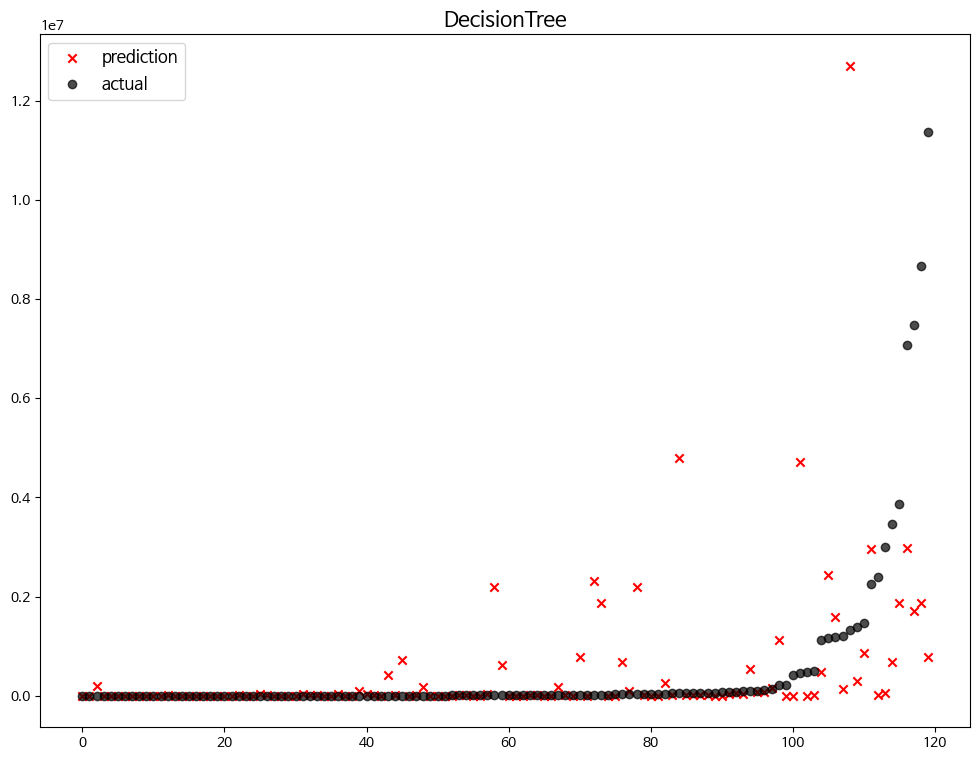

          model          rmse
0  DecisionTree  1.896937e+06


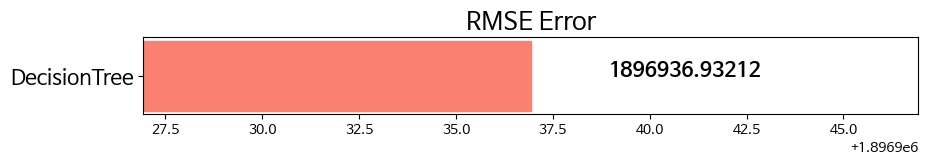

In [7]:
dt = DecisionTreeRegressor()
dt.fit(X_train_mm, y_train)
dt_pred = dt.predict(X_valid_mm)
rmse_eval('DecisionTree',dt_pred,y_valid)

### 2) 랜덤 포레스트 (Random Forest)

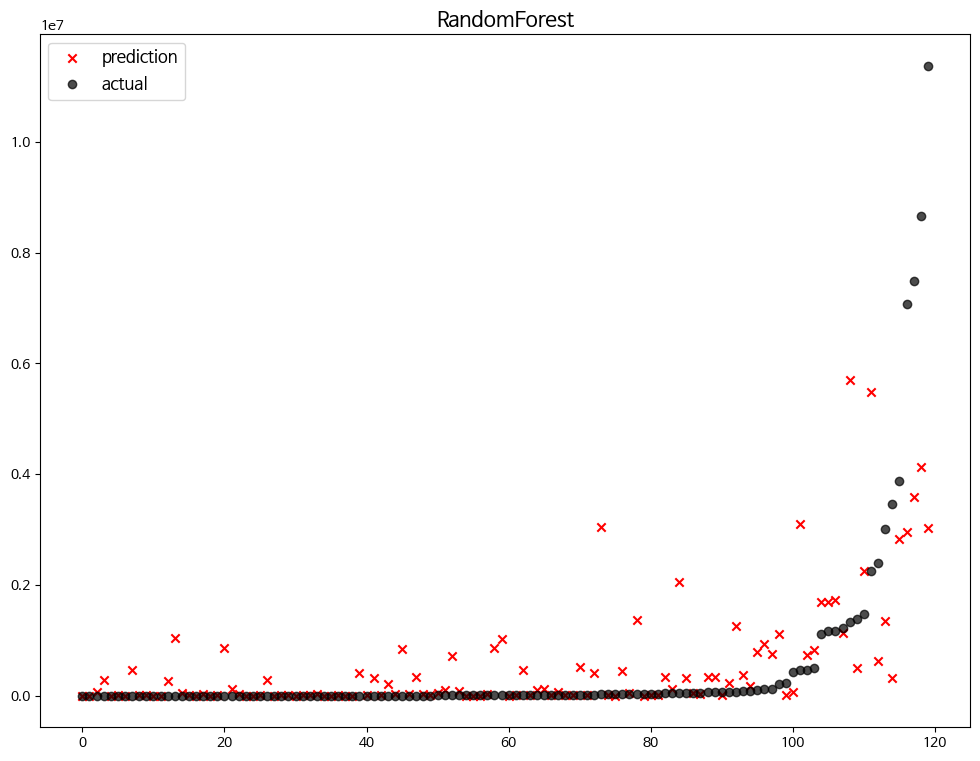

          model          rmse
0  DecisionTree  1.896937e+06
1  RandomForest  1.303319e+06


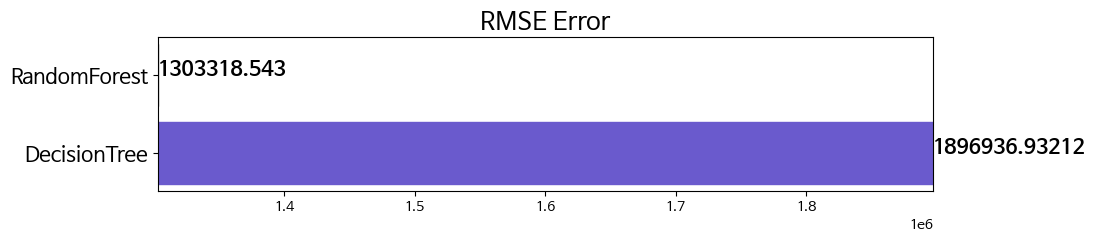

In [8]:
rfr = RandomForestRegressor()
rfr.fit(X_train_mm,y_train)
rfr_pred = rfr.predict(X_valid_mm)
rmse_eval('RandomForest',rfr_pred,y_valid)

### 제출

In [15]:
dt_final = dt.predict(X_test_mm)
dt_final = np.round(dt_final)
dt_final = pd.DataFrame(dt_final)
dt_final.head()

,0
0,616481.0
1,164252.0
2,1649407.0
3,4786259.0
4,164252.0


In [17]:
sub['box_off_num'] = dt_final
sub.head(10)

,title,box_off_num
0,용서는 없다,616481.0
1,아빠가 여자를 좋아해,164252.0
2,하모니,1649407.0
3,의형제,4786259.0
4,평행 이론,164252.0
5,회오리 바람,47105.0
6,경계도시 2,1217.0
7,이웃집 남자,335.0
8,아마존의 눈물 극장판,1693.0
9,반가운 살인자,402876.0


In [18]:
sub.to_csv('dt_final_submission.csv',index=False, encoding='utf-8-sig')

점수 : 1516448.0151573569

In [21]:
rfr_final = rfr.predict(X_test_mm)
rfr_final = np.round(rfr_final)
rfr_final = pd.DataFrame(rfr_final)
rfr_final.head()

,0
0,1867772.0
1,1480240.0
2,1930313.0
3,2486730.0
4,759608.0


In [22]:
sub['box_off_num'] = rfr_final
sub.head(10)

,title,box_off_num
0,용서는 없다,1867772.0
1,아빠가 여자를 좋아해,1480240.0
2,하모니,1930313.0
3,의형제,2486730.0
4,평행 이론,759608.0
5,회오리 바람,72897.0
6,경계도시 2,5218.0
7,이웃집 남자,1675.0
8,아마존의 눈물 극장판,66246.0
9,반가운 살인자,407151.0


In [23]:
sub.to_csv('rfr_final_submission.csv',index=False, encoding='utf-8-sig')

점수 : 1234349.6134671697